In [ ]:
!pip install tensorflow

import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
print("Number of GPUs available : ", len(tf.config.list_physical_devices('GPU')))

tf.test.gpu_device_name()

Number of GPUs available :  1


'/device:GPU:0'

### ***Image Data Generator***

In [ ]:
# https://youtu.be/PNqnLbzdxwQ
"""
Custom data generator to work with BraTS2020 dataset.
Can be used as a template to create your own custom data generators.
No image processing operations are performed here, just load data from local directory
in batches.
"""

#from tifffile import imsave, imread
import os
import numpy as np


def load_img(MRI_images_directory, MRI_images_list):

    images = []
    ground_truth_list = []

    for i, image_name in enumerate(MRI_images_list):
        if (image_name.split('.')[1] == 'npz'):

            image = np.load(MRI_images_directory+image_name)

            MRI_image = image['a']

            Ground_truth = image['b']

            images.append(MRI_image[:,:,30:142])

            ground_truth_list.append(Ground_truth[:,:,30:142])

            #ground_truth_list.append(Ground_truth[:,:,0:144])

            pass

        pass

    images = np.array(images)
    ground_truth_array = np.array(ground_truth_list)

    return(images,ground_truth_array)




def imageLoader(MRI_images_directory, MRI_images_list, batch_size):

    L = len(MRI_images_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X,Y = load_img(MRI_images_directory, MRI_images_list[batch_start:limit])
            #Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

############################################

### ***3D UNET Image Segmentation Model***

In [ ]:
# https://youtu.be/ScdCQqLtnis
"""
@author: Sreenivas Bhattiprolu
Converted my standard 2D Unet to 3D.
"""

!pip install Keras
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    model.summary()

    return model

#Test if everything is working ok.
model = simple_unet_model(240, 240, 144, 4, 6)
print(model.input_shape)
print(model.output_shape)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 240, 240, 1  0           []                               
                                44, 4)]                                                           
                                                                                                  
 conv3d_617 (Conv3D)            (None, 240, 240, 14  1744        ['input_34[0][0]']               
                                4, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 240, 240, 14  0           ['conv3d_617[0][0]']      

### ***Custom Model***

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda, Activation, UpSampling3D
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU

def custom_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):

    kernel_initializer =  'he_normal' #Try others if you want

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))

    s = inputs

    # Contraction path ------------------------------------------- ENCODER -------------------------------------------------



    #                 -------------------------------------------- Level 1 -------------------------------------------------


    #conv_1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)

    conv_1 = Conv3D(16, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(s)
    #conv_1 = Conv3D(16, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(conv_1)
    BN_1 = BatchNormalization()(conv_1)
    BN_1 = Activation("relu")(BN_1)

    pool_1 = MaxPooling3D((2, 2, 2))(BN_1)

    conv_1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(pool_1)



    #                 -------------------------------------------- Level 2 -------------------------------------------------


    #conv_2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(conv_1)

    conv_2 = Conv3D(32, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(conv_1)
    #conv_2 = Conv3D(32, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(conv_2)
    BN_2 = BatchNormalization()(conv_2)
    BN_2 = Activation("relu")(BN_2)

    pool_2 = MaxPooling3D((2, 2, 2))(BN_2)

    conv_2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(pool_2)

    #<--- concatination (skip connection) -->

    concat_1 = MaxPooling3D(pool_size=(2, 2, 2))(BN_1) # Encoder Level 1 feature
    concat_1 = MaxPooling3D(pool_size=(2, 2, 2))(concat_1)

    concat_1 = concatenate([conv_2,concat_1])


    #                 ------------------------------------------- Level 3 -------------------------------------------------


    #conv_3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(concat_1)

    conv_3 = Conv3D(64, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(concat_1)
    #conv_3 = Conv3D(64, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(conv_3)
    BN_3 = BatchNormalization()(conv_3)
    BN_3 = Activation("relu")(BN_3)

    pool_3 = MaxPooling3D((2, 2, 2))(BN_3)

    conv_3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(pool_3)

    #<--- concatination (skip connection) -->

    concat_2 = MaxPooling3D(pool_size=(2, 2, 2))(BN_2) # Encoder Level 2 feature map
    concat_2 = MaxPooling3D(pool_size=(2, 2, 2))(concat_2)

    concat_2 = concatenate([conv_3,concat_2])



    #                 ------------------------------------------- Level 4 -------------------------------------------------


    #conv_4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(concat_2)

    conv_4 = Conv3D(128, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(concat_2)
    #conv_4 = Conv3D(128, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(conv_4)
    BN_4 = BatchNormalization()(conv_4)
    BN_4 = Activation("relu")(BN_4)

    pool_4 = MaxPooling3D((2, 2, 2))(BN_4)

    conv_4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(pool_4)

    #<--- concatination (skip connection) -->

    concat_3 = MaxPooling3D(pool_size=(2, 2, 2))(BN_3) # Encoder Level 3 feature map
    concat_3 = MaxPooling3D(pool_size=(2, 2, 2))(concat_3)

    concat_3 = concatenate([conv_4,concat_3])


    #                 -------------------------------------------- Bridge -------------------------------------------------
    #                 -------------------------------------------- Level 0 -------------------------------------------------


    #conv_5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(concat_3)

    conv_5 = Conv3D(256, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(concat_3)
    #conv_5 = Conv3D(256, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(conv_5)
    BN_5 = BatchNormalization()(conv_5)
    BN_5 = Activation("relu")(BN_5)

    #pool_5 = MaxPooling3D((2, 2, 2))(BN_5)

    conv_5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(BN_5)

    #<--- concatination (skip connection) -->

    concat_4 = MaxPooling3D(pool_size=(2, 2, 2))(BN_4) # Encoder Level 4 feature map
    #concat_4 = MaxPooling3D(pool_size=(2, 2, 2))(concat_4)

    concat_4 = concatenate([conv_5,concat_4])




    # Expansion path ------------------------------------------- DECODER -------------------------------------------------


    #                 -------------------------------------------- Level 1 -------------------------------------------------


    upsamp_1 = UpSampling3D(size=(2, 2, 2))(concat_4) #upsampling increases the size of feature maps 64x64 -> 128x128

    conv_6 = Conv3D(128, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(upsamp_1)
    BN_6 = BatchNormalization()(conv_6)
    BN_6 = Activation("relu")(BN_6)


    #<--- concatination (skip connection) -->

    #features from encoder section level 4

    level_1_feature_map_1 = BN_4 #BN_4 feature map from encoder level 4

    concat_5 = concatenate([BN_6, level_1_feature_map_1])



    conv_6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(concat_5)

    #conv_6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(conv_6)


    #                 -------------------------------------------- Level 2 -------------------------------------------------


    upsamp_2 = UpSampling3D(size=(2, 2, 2))(conv_6) #upsampling increases the size of feature maps 64x64 -> 128x128

    conv_7 = Conv3D(64, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(upsamp_2)
    BN_7 = BatchNormalization()(conv_7)
    BN_7 = Activation("relu")(BN_7)

    #<--- concatination (skip connection) -->


    #features from encoder section level 3

    level_2_feature_map_1 = BN_3 #BN_3 feature map from encoder level 3

    #features from decoder section level 1

    level_2_feature_map_2 = UpSampling3D(size=(2, 2, 2))(BN_6)


    concat_6 = concatenate([BN_7,level_2_feature_map_1, level_2_feature_map_2])



    conv_7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(concat_6)

    #conv_7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(conv_7)


    #                 -------------------------------------------- Level 3 -------------------------------------------------




    upsamp_3 = UpSampling3D(size=(2, 2, 2))(conv_7) #upsampling increases the size of feature maps 64x64 -> 128x128

    conv_8 = Conv3D(32, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(upsamp_3)
    BN_8 = BatchNormalization()(conv_8)
    BN_8 = Activation("relu")(BN_8)

    #<--- concatination (skip connection) -->


    #features from encoder section level 2

    level_3_feature_map_1 = BN_2 #BN_2 feature map from encoder level 2

    #features from decoder section level 2

    level_3_feature_map_2 = UpSampling3D(size=(2, 2, 2))(BN_7)


    concat_7 = concatenate([BN_8,level_3_feature_map_1, level_3_feature_map_2])



    conv_8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(concat_7)

    #conv_8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(conv_8)



    #                 -------------------------------------------- Level 4 -------------------------------------------------




    upsamp_4 = UpSampling3D(size=(2, 2, 2))(conv_8) #upsampling increases the size of feature maps 64x64 -> 128x128

    conv_9 = Conv3D(16, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(upsamp_4)
    BN_9 = BatchNormalization()(conv_9)
    BN_9 = Activation("relu")(BN_9)

    #<--- concatination (skip connection) -->


    #features from encoder section level 1

    level_4_feature_map_1 = BN_1 #BN_1 feature map from encoder level 1

    #features from decoder section level 3

    level_4_feature_map_2 = UpSampling3D(size=(2, 2, 2))(BN_8)


    concat_8 = concatenate([BN_9,level_4_feature_map_1, level_4_feature_map_2])



    conv_9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(concat_8)

    #conv_9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(conv_9)




    #                 -------------------------------------------- output -------------------------------------------------

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(conv_9)


    model = Model(inputs=[inputs], outputs=[outputs])


    return model

model = custom_model(240, 240, 112, 4, 6)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                12, 4)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 240, 240, 11  1744        ['input_1[0][0]']                
                                2, 16)                                                            
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 11  64         ['conv3d[0][0]']                 
 alization)                     2, 16)                                                        

### ***Creating Batches Using Image data Generator***

In [ ]:
training_MRI_images_directory = '/content/drive/MyDrive/NPZ files/train/'

training_images_names = os.listdir(training_MRI_images_directory)


validation_MRI_images_directory = '/content/drive/MyDrive/NPZ files/validation/'

validation_images_names = os.listdir(validation_MRI_images_directory)


print("Training images :",len(training_images_names))
print("Validation Images :",len(validation_images_names))

#

training_images_names_list = training_images_names
validation_images_names_list = validation_images_names



Training images : 412
Validation Images : 105


### ***MRI Image Visualization***

(1, 160, 160, 112, 6)


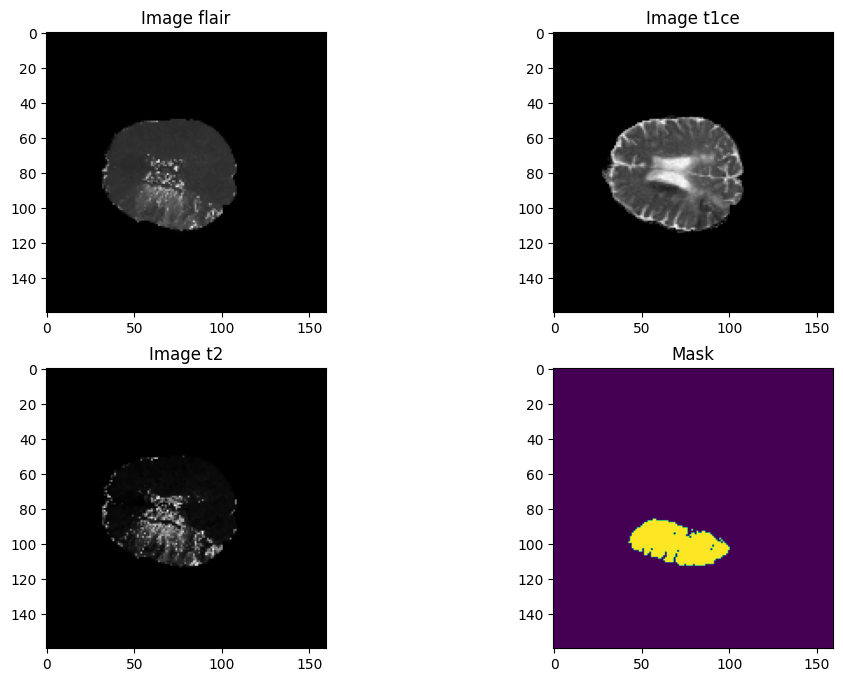

In [ ]:
batch_size = 1
train_image_data_generator = imageLoader(MRI_images_directory=training_MRI_images_directory,MRI_images_list=training_images_names_list,batch_size=batch_size)

"""for i in range(10):

  if i > 1:

    del X,Y

    pass
  X,Y = train_image_data_generator.__next__()

  pass



print(X.shape)
print(Y.shape)

"""

MRI_image_path = '/content/drive/MyDrive/NPZ files/train/spes_image_15.npz'
images = []
ground_truth_list = []

image = np.load(MRI_image_path)

MRI_image = image['a']

Ground_truth = image['b']

#images.append(MRI_image[56:184,56:184,13:141])

images.append(MRI_image[40:200,50:210,30:142])

ground_truth_list.append(Ground_truth[40:200,50:210,30:142])

print(np.asarray(ground_truth_list).shape)

images = np.array(images)
ground_truth_array = np.array(ground_truth_list)

X = images
Y = ground_truth_array

MRI_image = X[0]
Ground_truth = Y[0]

final_ground_truth = np.argmax(Ground_truth,axis=3)

n_slice = 57

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(MRI_image[:,:,n_slice, 3], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(MRI_image[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(MRI_image[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(final_ground_truth[:,:,n_slice])
plt.title('Mask')
plt.show()

### ***IMPORTING KERAS BACKEND FOR USING KERAS FUNCTIONS***

In [ ]:
from keras import backend as K

### ***DICE SIMILARITY COEFFICIENT***

In [ ]:
smooth = 1.

def dice_similarity_coefficient(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_similarity_coefficient(y_true, y_pred)

### ***JACCARD SIMILARITY COEFFICIENT***

In [ ]:
def jaccard_similarity_coefficient(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    return (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)

### ***IOU score as Performance Evaluation metric for Segmentation Model***

In [ ]:
!pip install segmentation-models-3D
import segmentation_models_3D as sm

IOU_score = sm.metrics.IOUScore(threshold=0.5)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 1.5 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


### ***Other Evaluation Metrics***

In [ ]:
import keras
from keras import backend as K

def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



Specificity = keras.metrics.SpecificityAtSensitivity(0.5)

Sensitivity = keras.metrics.SensitivityAtSpecificity(0.5)

precision_metric = keras.metrics.Precision(thresholds=0)

### ***Compiling Model and Model training using Image Data generator***

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.models import load_model


# defining batch size

batch_size = 1
############################################## Calling Image data generators

train_image_data_generator = imageLoader(MRI_images_directory=training_MRI_images_directory,MRI_images_list=training_images_names_list,batch_size=batch_size)


validation_image_data_generator = imageLoader(MRI_images_directory=validation_MRI_images_directory,MRI_images_list=validation_images_names_list,batch_size=batch_size)





# defining training steps on each epoch

steps_per_epoch = len(training_images_names_list)//batch_size
validation_steps_per_epoch = len(validation_images_names_list)//batch_size


############################################## Model performance evaluation metrices

metrics = ['accuracy',IOU_score,jaccard_similarity_coefficient,dice_similarity_coefficient,recall_score,precision_score,f1_score,Specificity,Sensitivity]


############################################## LOSS function

LR = 0.0001
optimizer = tf.keras.optimizers.Adam(LR)



############################################## initializing UNET MODEL
"""model = simple_unet_model(IMG_HEIGHT=240,
                          IMG_WIDTH=240,
                          IMG_DEPTH=144,
                          IMG_CHANNELS=4,
                          num_classes=6)"""



model = custom_model(IMG_HEIGHT=240,
                          IMG_WIDTH=240,
                          IMG_DEPTH=112,
                          IMG_CHANNELS=4,
                          num_classes=6)

############################################## Loading previously trained UNET MODEL
path = '/content/drive/MyDrive/brain_syndrome/multiple_brain_syndrome_segmentation_model.hdf5'

model = load_model(path,custom_objects={'iou_score':IOU_score,
                                        'jaccard_similarity_coefficient':jaccard_similarity_coefficient,
                                        'dice_similarity_coefficient':dice_similarity_coefficient,
                                        'recall_score':recall_score,'precision_score':precision_score,
                                         'f1_score':f1_score,'Specificity':Specificity,
                                          'Sensitivity':Sensitivity})


############################################# Compiling Model


model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=metrics)

                                        # Model Callbacks functions

##########################################################################################

#model_file_path = '/content/drive/MyDrive/brain_syndrome/multiple_brain_syndrome_segmentation_model.hdf5'

#csv_file_path = '/content/drive/MyDrive/brain_syndrome/multiple_brain_syndrome_segmentation_model_history.csv'

model_file_path = '/content/drive/MyDrive/brain_syndrome/customized_segmentation_model.hdf5'

csv_file_path = '/content/drive/MyDrive/brain_syndrome/customized_segmentation_model_history.csv'


history_logger = tf.keras.callbacks.CSVLogger(filename=csv_file_path,separator=",",append=True)

checkpoint = ModelCheckpoint(model_file_path, monitor="val_loss", save_best_only=False, verbose=2)

##########################################################################################



history=model.fit(train_image_data_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          callbacks=[[history_logger],[checkpoint]],
          verbose=1,
          validation_data=validation_image_data_generator,
          validation_steps=validation_steps_per_epoch,
          )


model.save('/content/drive/MyDrive/brain_syndrome/customized_segmentation_model.hdf5')

Epoch 1/100
412/412 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9982 - iou_score: 0.7982 - jaccard_similarity_coefficient: 0.9948 - dice_similarity_coefficient: 0.9974 - recall_score: 0.9980 - precision_score: 0.9984 - f1_score: 0.9982 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 1.0000
Epoch 1: saving model to /content/drive/MyDrive/brain_syndrome/multiple_brain_syndrome_segmentation_model.hdf5
412/412 [==============================] - 1862s 4s/step - loss: 0.0047 - accuracy: 0.9982 - iou_score: 0.7982 - jaccard_similarity_coefficient: 0.9948 - dice_similarity_coefficient: 0.9974 - recall_score: 0.9980 - precision_score: 0.9984 - f1_score: 0.9982 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 1.0000 - val_loss: 0.0290 - val_accuracy: 0.9945 - val_iou_score: 0.6071 - val_jaccard_similarity_coefficient: 0.9878 - val_dice_similarity_coefficient: 0.9938 - val_recall_score: 0.9942 - val_precision_score: 0.9949 - val_f1_

1/1 [==============================] - 17s 17s/step
(1, 240, 240, 144, 6)


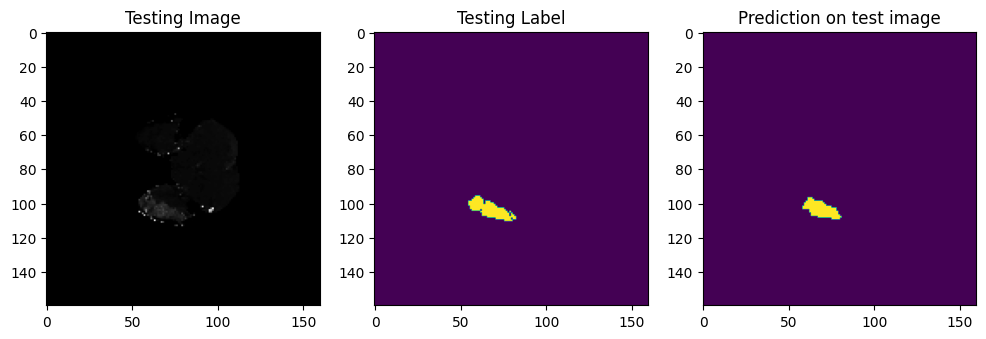

In [ ]:
# prediction

#################################################
from keras.models import load_model



my_model = load_model('/content/drive/MyDrive/brain_syndrome/multiple_brain_syndrome_segmentation_model.hdf5',
                      compile=False)

MRI_image_path = '/content/drive/MyDrive/NPZ files/train/spes_image_8.npz'
images = []
ground_truth_list = []

image = np.load(MRI_image_path)

MRI_image = image['a']

Ground_truth = image['b']

images.append(MRI_image[:,:,0:144])

ground_truth_list.append(Ground_truth[:,:,0:144])


images = np.array(images)
ground_truth_array = np.array(ground_truth_list)

X = images
Y = ground_truth_array

MRI_image = X[0]

ground_truth = Y[0]


final_ground_truth = np.argmax(ground_truth,axis=3)


prediction = my_model.predict(X)

print(prediction.shape)

final_prediction = np.argmax(prediction,axis=4)[0,:,:,:]

n_slice = 63

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(MRI_image[40:200,50:210,n_slice,2], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(final_ground_truth[40:200,50:210,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(final_prediction[40:200,50:210, n_slice])
plt.show()

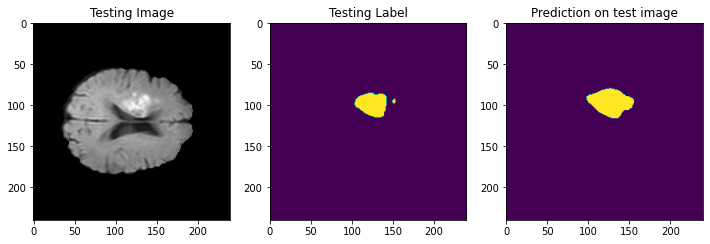

[0 4]


In [ ]:
n_slice = 96

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(MRI_image[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(final_ground_truth[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(final_prediction[:,:, n_slice])
plt.show()

print(np.unique(final_prediction))

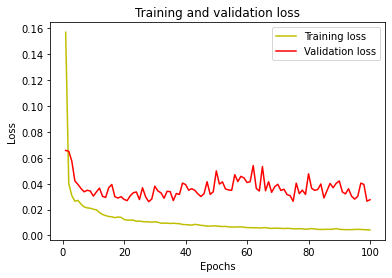

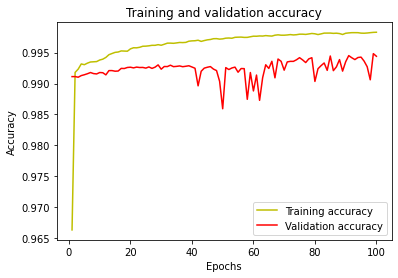

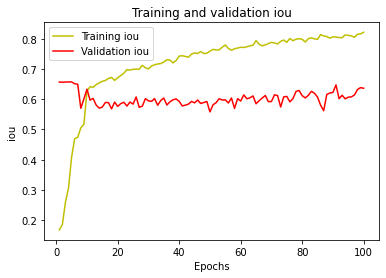

Epoches :  100


In [ ]:
import pandas as pd
csv_file_path = "/content/drive/MyDrive/brain_syndrome/multiple_brain_syndrome_segmentation_model_history.csv"

training_history_dataframe = pd.read_csv(csv_file_path)


##################################################################


#plot the training and validation IoU and loss at each epoch
loss = np.array(training_history_dataframe['loss'])
val_loss = np.array(training_history_dataframe['val_loss'])
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = np.array(training_history_dataframe['accuracy'])
val_acc = np.array(training_history_dataframe['val_accuracy'])

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

iou = np.array(training_history_dataframe['iou_score'])
val_iou = np.array(training_history_dataframe['val_iou_score'])

plt.plot(epochs, iou, 'y', label='Training iou')
plt.plot(epochs, val_iou, 'r', label='Validation iou')
plt.title('Training and validation iou')
plt.xlabel('Epochs')
plt.ylabel('iou')
plt.legend()
plt.show()


print("Epoches : ",len(epochs))
#################################################

### extra work

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.models import load_model


############################################## Model performance evaluation metrices

metrics = ['accuracy',IOU_score,jaccard_similarity_coefficient,dice_similarity_coefficient]


############################################## LOSS function

LR = 0.0001
optimizer = tf.keras.optimizers.Adam(LR)


MRI_image_path = '/content/drive/MyDrive/NPZ files/train/spes_image_19.npz'
images = []
ground_truth_list = []

image = np.load(MRI_image_path)

MRI_image = image['a']

Ground_truth = image['b']

#images.append(MRI_image[56:184,56:184,13:141])

images.append(MRI_image[:,:,30:142])

ground_truth_list.append(Ground_truth[:,:,30:142])


images = np.array(images)
ground_truth_array = np.array(ground_truth_list)

X = images
Y = ground_truth_array



model = custom_model(IMG_HEIGHT=240,
                          IMG_WIDTH=240,
                          IMG_DEPTH=112,
                          IMG_CHANNELS=4,
                          num_classes=6)



############################################# Compiling Model


model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=metrics)

history=model.fit(X,Y,
          epochs=500,
          verbose=1,
          )



Epoch 1/500
1/1 [==============================] - 72s 72s/step - loss: 2.0713 - accuracy: 0.0425 - iou_score: 0.0011 - jaccard_similarity_coefficient: 0.0748 - dice_similarity_coefficient: 0.1391
Epoch 2/500
1/1 [==============================] - 3s 3s/step - loss: 1.8417 - accuracy: 0.0660 - iou_score: 0.0081 - jaccard_similarity_coefficient: 0.0958 - dice_similarity_coefficient: 0.1748
Epoch 3/500
1/1 [==============================] - 3s 3s/step - loss: 1.6103 - accuracy: 0.5405 - iou_score: 0.0201 - jaccard_similarity_coefficient: 0.1223 - dice_similarity_coefficient: 0.2180
Epoch 4/500
1/1 [==============================] - 3s 3s/step - loss: 1.4910 - accuracy: 0.6721 - iou_score: 0.0199 - jaccard_similarity_coefficient: 0.1396 - dice_similarity_coefficient: 0.2450
Epoch 5/500
1/1 [==============================] - 3s 3s/step - loss: 1.3813 - accuracy: 0.8496 - iou_score: 0.0233 - jaccard_similarity_coefficient: 0.1573 - dice_similarity_coefficient: 0.2719
Epoch 6/500
1/1 [======

1/1 [==============================] - 2s 2s/step
(1, 240, 240, 112, 6)


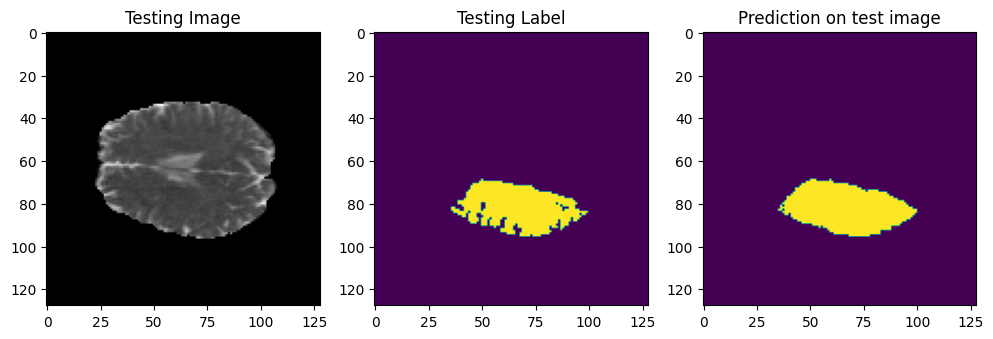

In [ ]:
prediction = model.predict(X)

ground_truth = Y[0]

final_ground_truth = np.argmax(ground_truth,axis=3)

print(prediction.shape)

final_prediction = np.argmax(prediction,axis=4)[0,:,:,:]

n_slice = 57

MRI = X[0]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(MRI[56:184,56:184,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(final_ground_truth[56:184,56:184,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(final_prediction[56:184,56:184, n_slice])
plt.show()

In [ ]:
##################################################################


#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
#epochs = range(1, len(loss) + 1)

epochs = range(0, 100)
plt.plot(epochs, loss[0:100], 'y', label='Training loss')
plt.plot(epochs, val_loss[0:100], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc[0:100], 'y', label='Training accuracy')
plt.plot(epochs, val_acc[0:100], 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#################################################